In [4]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier


In [51]:
msft = yf.Ticker("UBER")
data = msft.history(interval = "1d", period="7Y")
data["log_ret"] = np.log(data.Close) - np.log(data.Close.shift(1))
data["RSILR"] =ta.rsi(data.log_ret, length=15)
data["EMAFLR"]=ta.ema(data.log_ret, length=25)
data["EMAMLR"]=ta.ema(data.log_ret, length=100)
data["EMASLR"]=ta.ema(data.log_ret, length=150)
data["log_ret_next"] = data["log_ret"].shift(-1)
data["Target"] = (data["log_ret_next"] > data["log_ret"]).astype(int)
data.dropna(inplace=True)
data.reset_index(inplace=True)
dates = data["Date"]
data.drop(["Volume", "Close", "Date", "Open", "High", "Low", "Dividends", "Stock Splits"], axis=1, inplace=True)
data

,log_ret,RSILR,EMAFLR,EMAMLR,EMASLR,log_ret_next,Target
0,0.018825,52.960167,-0.000903,-0.001878,-0.002552,0.009456,0
1,0.009456,51.525777,-0.000106,-0.001653,-0.002393,-0.006996,0
2,-0.006996,49.027714,-0.000636,-0.001759,-0.002454,0.053309,1
3,0.053309,57.181095,0.003513,-0.000669,-0.001716,-0.010034,0
4,-0.010034,48.457881,0.002471,-0.000854,-0.001826,0.012692,1
...,...,...,...,...,...,...,...
1035,-0.008745,47.501077,0.002635,0.003501,0.003297,0.034529,1
1036,0.034529,55.769216,0.005088,0.004116,0.003711,-0.007299,0
1037,-0.007299,47.948552,0.004135,0.003889,0.003565,0.022039,1
1038,0.022039,52.910995,0.005513,0.004249,0.003809,-0.002092,0


In [52]:
predictors = ["log_ret", "RSILR", "EMAFLR", "EMAMLR", "EMASLR"]
train = data.iloc[:-100]
test = data.iloc[-100:]

In [9]:
estimators = np.arange(25,250,25)
train_accuracies = {}
test_accuracies = {}
for estimator in estimators:
    model = RandomForestClassifier(n_estimators = estimator, min_samples_split = 100, random_state = 1)
    model.fit(train[predictors], train["Target"])
    train_accuracies[estimator] = model.score(train[predictors], train["Target"])
    test_accuracies[estimator] = model.score(test[predictors], test["Target"])

In [ ]:
plt.plot(estimators, train_accuracies.values(), label="Training Accuracy")
plt.plot(estimators, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")

In [ ]:
samplesplits = np.arange(25,250,25)
train_accuracies = {}
test_accuracies = {}
for samplesplit in samplesplits:
    model = RandomForestClassifier(n_estimators = 25, min_samples_split = samplesplit, random_state = 1)
    model.fit(train[predictors], train["Target"])
    train_accuracies[samplesplit] = model.score(train[predictors], train["Target"])
    test_accuracies[samplesplit] = model.score(test[predictors], test["Target"])

In [ ]:
plt.plot(samplesplits, train_accuracies.values(), label="Training Accuracy")
plt.plot(samplesplits, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.xlabel("Min Sample Split")
plt.ylabel("Accuracy")

In [53]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=100, random_state=1)
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=25, random_state=1)

In [54]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.7435897435897436

In [29]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=200, step=50):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [30]:
predictions = backtest(data, model, predictors)
predictions["Predictions"].value_counts()

Predictions
0.0    838
1.0    573
Name: count, dtype: int64

In [31]:
precision_score(predictions["Target"], predictions["Predictions"])

0.7853403141361257

[Text(0.5357142857142857, 0.9285714285714286, 'RSILR <= 48.74\ngini = 0.5\nsamples = 602\nvalue = [465, 475]'),
 Text(0.35714285714285715, 0.7857142857142857, 'EMAFLR <= -0.001\ngini = 0.268\nsamples = 208\nvalue = [52, 274]'),
 Text(0.2857142857142857, 0.6428571428571429, 'log_ret <= -0.013\ngini = 0.176\nsamples = 113\nvalue = [17, 157]'),
 Text(0.21428571428571427, 0.5, 'EMAMLR <= 0.003\ngini = 0.168\nsamples = 112\nvalue = [16, 157]'),
 Text(0.14285714285714285, 0.35714285714285715, 'EMAMLR <= -0.01\ngini = 0.159\nsamples = 111\nvalue = [15, 157]'),
 Text(0.07142857142857142, 0.21428571428571427, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.21428571428571427, 0.21428571428571427, 'EMAMLR <= -0.0\ngini = 0.151\nsamples = 109\nvalue = [14, 156]'),
 Text(0.14285714285714285, 0.07142857142857142, 'gini = 0.183\nsamples = 87\nvalue = [14, 123]'),
 Text(0.2857142857142857, 0.07142857142857142, 'gini = 0.0\nsamples = 22\nvalue = [0, 33]'),
 Text(0.2857142857142857, 0.35714285714285

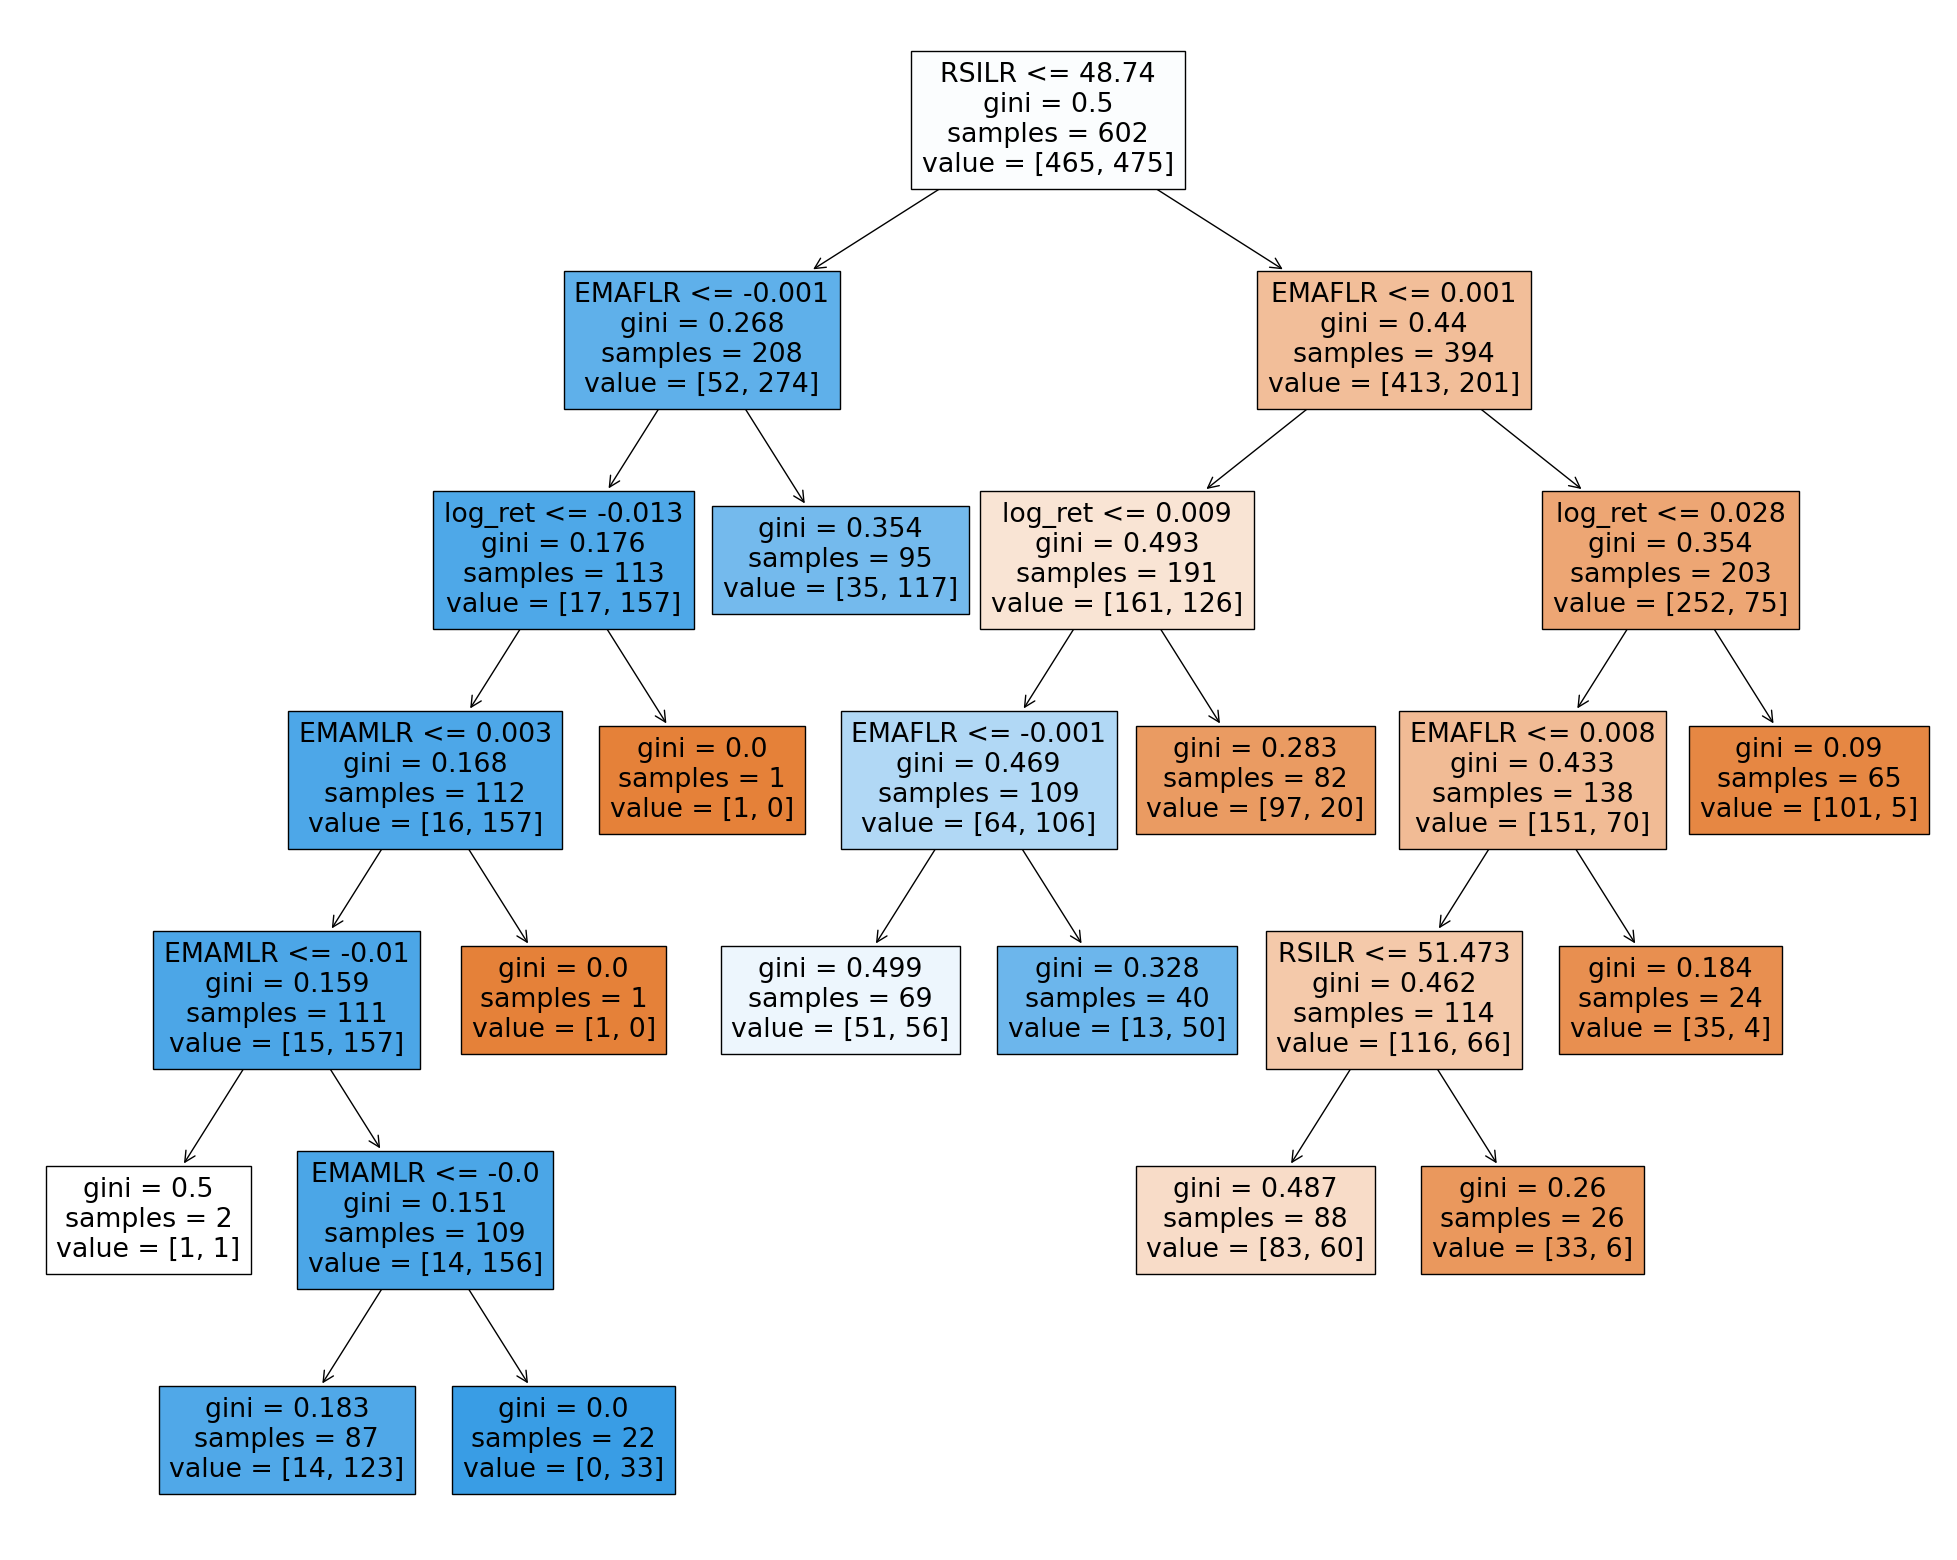

In [55]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,20))
plot_tree(model.estimators_[0],
          feature_names = predictors,
          filled = True)

In [56]:
print(preds)

940     0
941     0
942     0
943     1
944     0
       ..
1035    1
1036    0
1037    1
1038    0
1039    0
Length: 100, dtype: int32
